## Functie pentru a plota imaginile

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, title: str = None):
        if title:
            plt.title(title)
        plt.imshow(image)
        plt.show()

## Functie pentru a descarca arhiva cu setul de date si mastile corespunzatoare



In [ ]:
import requests
from zipfile import ZipFile
from io import BytesIO
import shutil

def download_dataset(save_path):
    r = requests.get("https://drive.google.com/uc?id=1c1ZAG9Luk5tk3Zp2BBh4qAqS9chbvHyF&export=download&confirm=t&uuid=1b390632-5764-4fb8-bb41-b89c31e49b4b&at=AKKF8vzC3PYAqGQd-T8nJ2g2V0OR:1686729801060")
    print("Downloading dataset...")
    z = ZipFile(BytesIO(r.content))
    z.extractall(save_path)
    print("Completed downloading dataset...")

## Functii pentru a prelucra imaginile

In [ ]:
import os
import numpy as np
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted


def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_images(path,resize_shape=(512, 512)):
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images_files = [dirs[0]]
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images=convert_one_channel(np.asarray(images))
    for i in range (1,len(dirs)):
        images_files.append(dirs[i])
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images, sizes, images_files

def pre_masks(path, resize_shape=(512,512)):
    dirs=natsorted(os.listdir(path))
    masks=img=Image.open(path+dirs[0])
    masks=(masks.resize((resize_shape),Image.ANTIALIAS))
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),resize_shape[0],resize_shape[1],1))
    return masks

## Descarcam setul de date

In [ ]:
path = "data/"
if not os.path.exists(path):
    os.mkdir(path)
download_dataset(path)

Completed downloading dataset...


## Functie pentru a incarca imaginile

In [ ]:
img_size = (512, 512)
data = {}
data['input'], data['inputs_sizes'], data['image_names'] = pre_images(path + 'original/', resize_shape=img_size)
data['output'] = pre_masks(path + 'masks/', resize_shape=img_size)

data['input'] = np.float32(data['input'] / 255.0)
data['output'] = np.float32(data['output'] / 255.0)

## Modelul folosit si rezumatul acestuia

In [ ]:
import tensorflow as tf
from keras import layers

last_activation='sigmoid'

inputs=tf.keras.Input(shape=(img_size[0], img_size[1], 1))

conv1 = layers.Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
d1 = layers.Dropout(0.1)(conv1)
conv2 = layers.Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
b = layers.BatchNormalization()(conv2)

pool1 = layers.MaxPooling2D(pool_size=(2, 2))(b)
conv3 = layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
d2 = layers.Dropout(0.2)(conv3)
conv4 = layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
b1 = layers.BatchNormalization()(conv4)

pool2 = layers.MaxPooling2D(pool_size=(2, 2))(b1)
conv5 = layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
d3 = layers.Dropout(0.3)(conv5)
conv6 = layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
b2 = layers.BatchNormalization()(conv6)

pool3 = layers.MaxPooling2D(pool_size=(2, 2))(b2)
conv7 = layers.Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
d4 = layers.Dropout(0.4)(conv7)
conv8 = layers.Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
b3 = layers.BatchNormalization()(conv8)

pool4 = layers.MaxPooling2D(pool_size=(2, 2))(b3)
conv9 = layers.Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
d5 = layers.Dropout(0.5)(conv9)
conv10 = layers.Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
b4 = layers.BatchNormalization()(conv10)

conv11 = layers.Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
x = layers.concatenate([conv11,conv8])
conv12 = layers.Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
d6 = layers.Dropout(0.4)(conv12)
conv13 = layers.Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
b5 = layers.BatchNormalization()(conv13)


conv14 = layers.Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
x1 = layers.concatenate([conv14,conv6])
conv15 = layers.Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
d7 = layers.Dropout(0.3)(conv15)
conv16 = layers.Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
b6 = layers.BatchNormalization()(conv16)

conv17 = layers.Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
x2 = layers.concatenate([conv17,conv4])
conv18 = layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
d8 = layers.Dropout(0.2)(conv18)
conv19 = layers.Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
b7 = layers.BatchNormalization()(conv19)

conv20 = layers.Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
x3 = layers.concatenate([conv20,conv2])
conv21 = layers.Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
d9 = layers.Dropout(0.1)(conv21)
conv22 = layers.Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)

outputs = layers.Conv2D(1,(1,1), activation = last_activation, padding = 'same', kernel_initializer = 'he_normal')(conv22)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

## Afisarea modelului

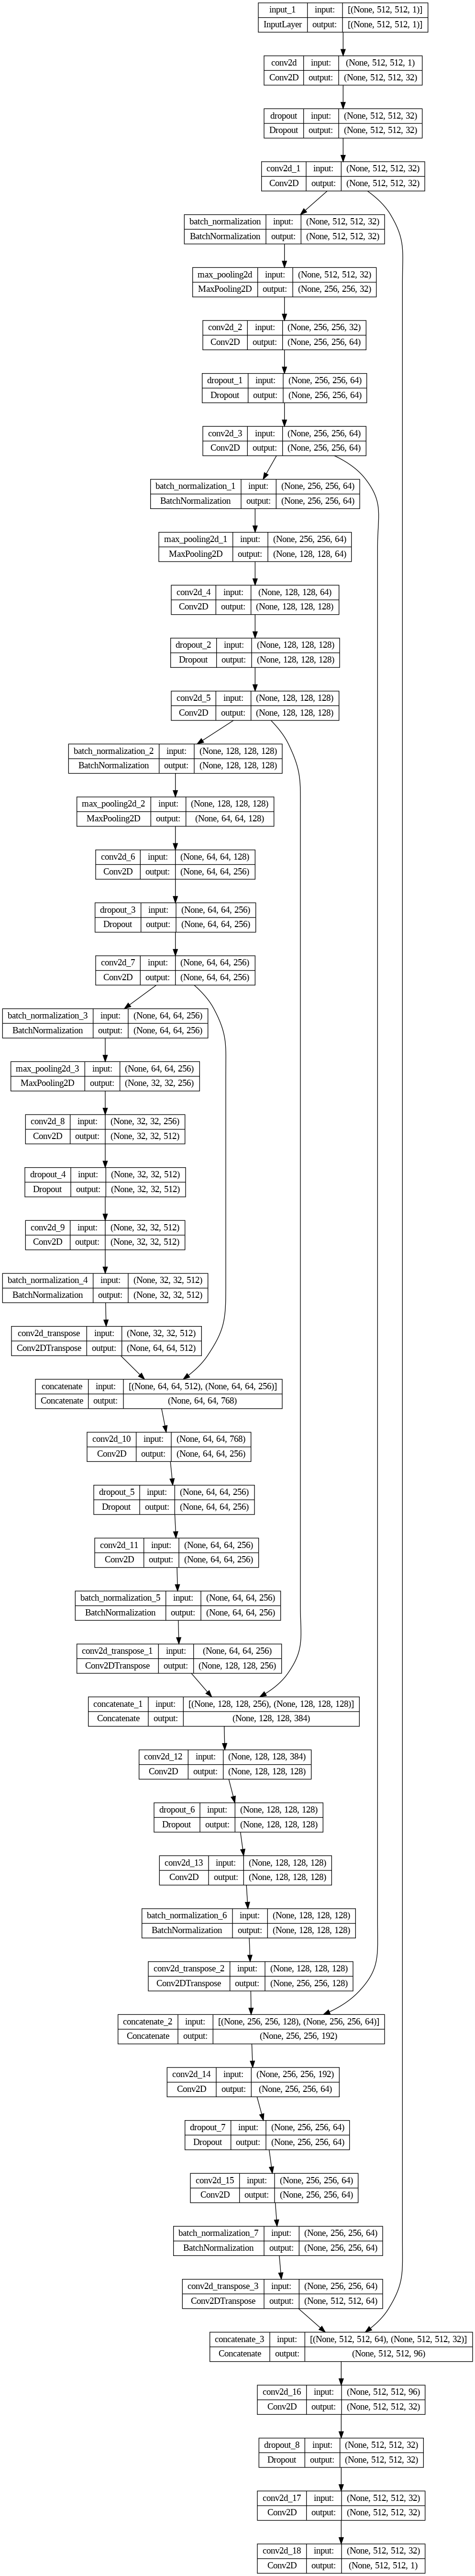

In [ ]:
from IPython.display import Image

img = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,
                                to_file='model.png')
Image('model.png')

## Impartim setul de date in train si test (80% - 20%)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data['input'], data['output'], test_size=0.2, random_state=1
)

## Plotarea unor imagini din setul de date folosit

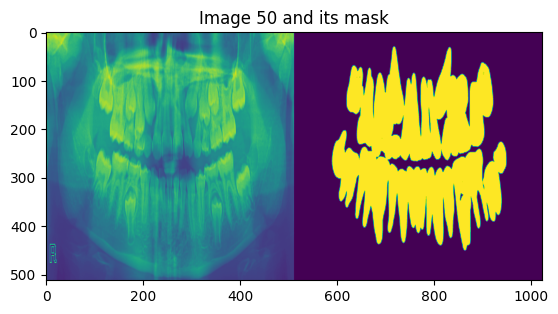

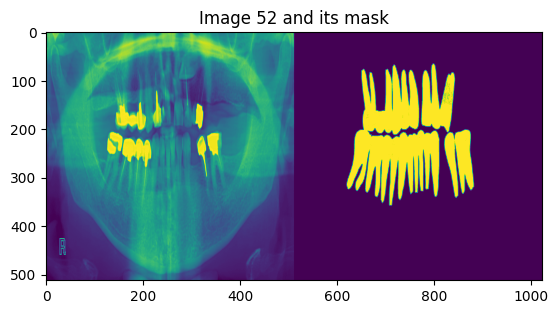

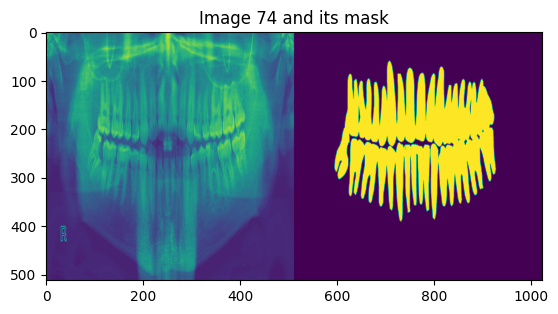

In [ ]:
import random

len_input = len(X_train)
for _ in range(3):
    idx = random.randint(0, len_input - 1)
    img = np.concatenate((X_train[idx], y_train[idx]), axis=1)
    plot_image(img, title=f'Image {idx} and its mask')

## Augmentarea datelor

Deoarece setul de date nu este unul foarte mare, o sa augmentam datele (rotatii, shiftari, scalari, blur, etc). Facem acest lucru pentru ca modelul sa poata fi folosit pentru date mai diverse. Trebuie sa augmentam si input-ul si output-ul, deci este nevoie de cod propriu pentru aceasta.

In [ ]:
import cv2

import albumentations as A

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),
                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

X_train1 = np.copy(X_train)
y_train1 = np.copy(y_train)
for _ in range(2):
    X_aug2 = np.copy(X_train1)
    y_aug2 = np.copy(y_train1)
    for i in range(len(X_train1)):
        augmented = aug(image=X_train1[i,:,:,:],mask=y_train1[i,:,:,:])
        X_aug2[i,:,:,:] = augmented['image']
        y_aug2[i,:,:,:] = augmented['mask']
    X_train = np.concatenate((X_train,X_aug2))
    y_train = np.concatenate((y_train,y_aug2))
    del y_aug2
    del X_aug2
    del augmented
del y_train1
del X_train1

## Plotarea unor imagini din setul de date augmentat

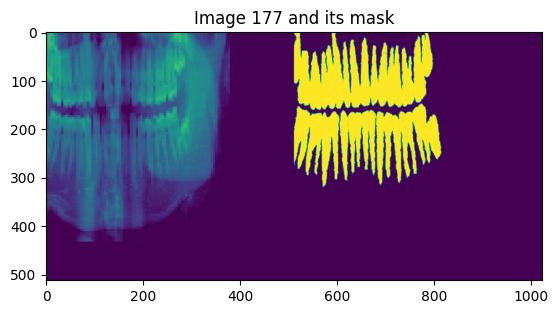

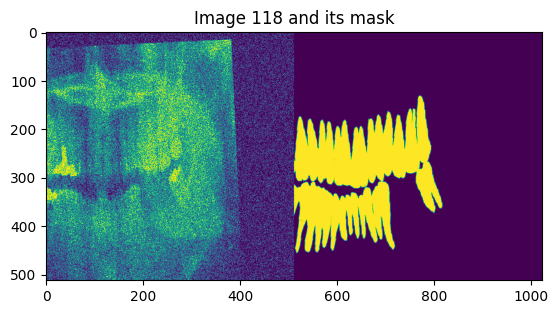

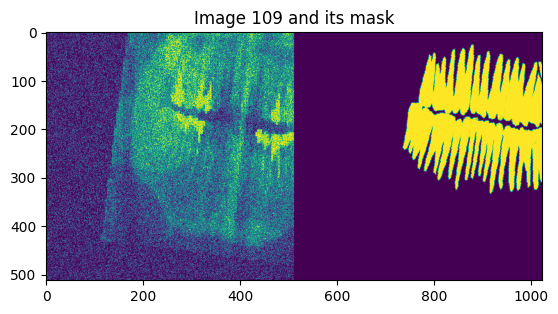

In [54]:
import random

len_input = len(X_train)
for _ in range(3):
    idx = random.randint(0, len_input - 1)
    img = np.concatenate((X_train[idx], y_train[idx]), axis=1)
    plot_image(img, title=f'Image {idx} and its mask')

## Antrenam modelul pentru setul de date

In [55]:
model.compile(optimizer='adam', loss='binary_focal_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=8, epochs=50, verbose=1)

Epoch 1/50
35/35 [==============================] - 51s 1s/step - loss: 0.0219 - accuracy: 0.9173
Epoch 2/50
35/35 [==============================] - 40s 1s/step - loss: 0.0206 - accuracy: 0.9182
Epoch 3/50
35/35 [==============================] - 41s 1s/step - loss: 0.0203 - accuracy: 0.9187
Epoch 4/50
35/35 [==============================] - 41s 1s/step - loss: 0.0217 - accuracy: 0.9170
Epoch 5/50
35/35 [==============================] - 42s 1s/step - loss: 0.0208 - accuracy: 0.9180
Epoch 6/50
35/35 [==============================] - 42s 1s/step - loss: 0.0204 - accuracy: 0.9185
Epoch 7/50
35/35 [==============================] - 42s 1s/step - loss: 0.0195 - accuracy: 0.9195
Epoch 8/50
35/35 [==============================] - 42s 1s/step - loss: 0.0193 - accuracy: 0.9196
Epoch 9/50
35/35 [==============================] - 42s 1s/step - loss: 0.0188 - accuracy: 0.9203
Epoch 10/50
35/35 [==============================] - 42s 1s/step - loss: 0.0186 - accuracy: 0.9205
Epoch 11/50
35/35 [

## Salvam modelul

In [56]:
model.save('model/dental_data_model')

## Arhivam modelul

In [57]:
!zip -r './dental_data_model.zip' './model/dental_data_model'

  adding: model/dental_data_model/ (stored 0%)
  adding: model/dental_data_model/variables/ (stored 0%)
  adding: model/dental_data_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model/dental_data_model/variables/variables.index (deflated 75%)
  adding: model/dental_data_model/assets/ (stored 0%)
  adding: model/dental_data_model/keras_metadata.pb (deflated 95%)
  adding: model/dental_data_model/fingerprint.pb (stored 0%)
  adding: model/dental_data_model/saved_model.pb (deflated 90%)


## Dezarhivam modelul

In [ ]:
if not os.path.exists('model/'):
    os.mkdir('model/')

!unzip './model/dental_data_model.zip' -d '.'

Archive:  /content/model/dental_data_model.zip
   creating: /content/model/dental_data_model/content/model/dental_data_model/
   creating: /content/model/dental_data_model/content/model/dental_data_model/variables/
  inflating: /content/model/dental_data_model/content/model/dental_data_model/variables/variables.data-00000-of-00001  
  inflating: /content/model/dental_data_model/content/model/dental_data_model/variables/variables.index  
   creating: /content/model/dental_data_model/content/model/dental_data_model/assets/
  inflating: /content/model/dental_data_model/content/model/dental_data_model/keras_metadata.pb  
 extracting: /content/model/dental_data_model/content/model/dental_data_model/fingerprint.pb  
  inflating: /content/model/dental_data_model/content/model/dental_data_model/saved_model.pb  


## Importam modelul

In [ ]:
model = tf.keras.models.load_model('model/dental_data_model')

## Lista de masti prezisa de model

In [58]:
predict_img = model.predict(X_test)
predict = predict_img[1,:,:,0]

1/1 [==============================] - 0s 357ms/step


## Testam modelul folosind F1 Score (Rapel + Precizie)

In [59]:
from sklearn.metrics import f1_score
import numpy as np

threshold = 0.25
pred_img_full = (predict_img > threshold) * 1
y_test_full = (y_test > threshold) * 1

print('F1 score:', end=' ')
f1_score(pred_img_full.flatten(), y_test_full.flatten(), average='micro')

F1 score: 

0.9524629910786947

## Afisam cateva dintre rezultate

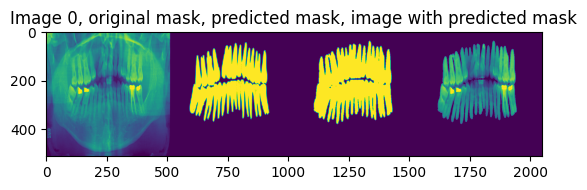

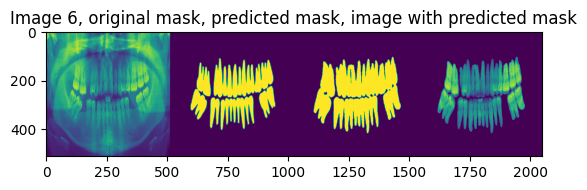

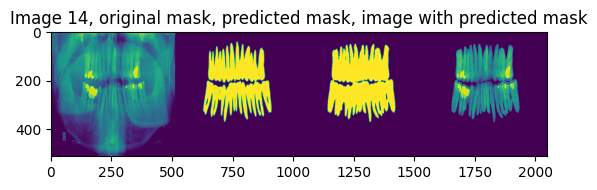

In [60]:
len_input = len(X_test)
for _ in range(3):
    idx = random.randint(0, len_input - 1)
    applied_mask = []
    len_img = len(X_test[idx])
    orig_img = np.int32(X_test[idx] * 255)
    orig_mask = np.int32(y_test[idx] * 255)
    pred_mask = np.int32(pred_img_full[idx] * 255)
    applied_mask = [[[i] for i in row] for row in cv2.bitwise_and(orig_img, pred_mask)]
    img = np.concatenate((orig_img, orig_mask, pred_mask, applied_mask), axis=1)
    # img = np.concatenate((img, applied_mask), axis=1)
    plot_image(img, title=f'Image {idx}, original mask, predicted mask, image with predicted mask')